In [1]:
from obspy import UTCDateTime
import obspy
import obspy.io.sac.sactrace
from obspy.taup import TauPyModel
from obspy import read_inventory
from obspy.clients.iris import Client
client = Client()
import os
import glob

In [2]:
def theo_arrival(data_dir, model_name, phase):
    """
    Write theoretical arrival times of P waves
    """
    model = TauPyModel(model=model_name)

    for ev in os.listdir(data_dir):
        print(ev)
        inpath = os.path.join(data_dir, ev)

        for sacfile in glob.glob('{}/*.SAC'.format(inpath)):

            st = obspy.read(sacfile)
            sachd = st[0].stats.sac
            
            # set P-wave first arrival
            distaz = client.distaz(sachd["stla"], sachd["stlo"], sachd["evla"], sachd["evlo"])
            gcarc = distaz['distance']
            arrivals = model.get_travel_times(source_depth_in_km=sachd["evdp"],
                                  distance_in_degree=gcarc, phase_list=[phase])
            
            sachd["t1"] = arrivals[0].time + sachd["o"]
            sachd["kt1"] = arrivals[0].name
            
            st[0].write(sacfile, format="SAC")

In [3]:
def read_evt(evtf):
    """
    read event information
    """
    with open(evtf, 'r') as f:
        lines = f.readlines()[1:]
        events = []
        dnames = []
        enum = 0
        for line in lines:
            enum += 1
            if (enum<=5):
                print("No:{}  evt:{}".format(enum,line))
                line = line.strip()
                temp = line.split(',')
                t = UTCDateTime(temp[0])
                lat, lon = float(temp[1]), float(temp[2])
                depth = float(temp[3])
                dpu = temp[4]
                mag = float(temp[5])
                magt = temp[6]
                events.append([t, lat, lon, depth, dpu, mag, magt])
                dnames.append("".join(temp[0].split("T")[0].split("-")) + "".join("".join("".join(temp[0].split("T")[1].split("Z")).split(".")).split(":")))
        return dnames, events

In [4]:

def mseed2sac(data_root, data_out, data_staxml, dnames, events):
    """
    convert miniseed to SAC
    """
    for evt in zip(dnames, events):
        outd = os.path.join(data_out, evt[0])
        if not os.path.exists(outd):
            os.makedirs(outd)

            fpath = os.path.join(data_root, evt[0], '*.mseed')
            try:
                st = obspy.read(fpath)
            except FileNotFoundError:
                print("Missing File: %s" % fpath)
                continue
    
            for tr in st:
                outfile = "{}.{}".format(tr.stats.network,tr.stats.station)
              #  print(outfile)
           
            # get the staxml
                stas = read_inventory(f"{data_staxml}/{outfile}.xml")
                
            # remove the response
                trace = tr.copy()
                inv = read_inventory()
                trace.remove_response(inventory=stas) 
            # convert to SACTrace from ObsPy Trace
                sactr = obspy.io.sac.SACTrace.from_obspy_trace(trace)
            
            # set event origin time as SAC reference time
                sactr.reftime = evt[1][0]
                sactr.o = 0
                sactr.iztype = 'io'

            # set station location
                sactr.stla = stas[0][0].latitude
                sactr.stlo = stas[0][0].longitude
                sactr.stel = stas[0][0].elevation
            
            # set event location and magnitude
                sactr.evla = evt[1][1]
                sactr.evlo = evt[1][2]
                sactr.evdp = evt[1][3]
                sactr.mag = evt[1][5]
            
            # set cmpaz and cmpinc
                sactr.cmpaz = stas[0][0][0].azimuth
                sactr.cmpinc = stas[0][0][0].dip + 90
            
            # other SAC headers
                sactr.lcalda = 1  # DIST AZ BAZ and GCARC headers will be calculated from station and event coordinates.
                              # Note that thing may not be same if we use ObsPy Trace.
            
            # write to sac files
                sactr.write(os.path.join(outd, tr.id+'.SAC'))

In [5]:
# dirs and files
#datadir = '/home/tianjue/SPMS/NCA/Data'

datadir = "/home/ketan/IndiaConnectNTU/Week5-6/DownloadData/Data"
evt_lst = f'{datadir}/events.csv'     

chan = ['BHN', 'BHE', 'BHZ']
for ch in chan:
    data_mseed = f'{datadir}/Download3/miniseed{ch}'    
    data_staxml = f'{datadir}/Download3/stations{ch}'
    data_sac = f'{datadir}/Download3/SAC{ch}'                    

    if not os.path.exists(data_sac):
        os.makedirs(data_sac)

    # read event metadata
    dnames, events = read_evt(evt_lst)

    # convert miniseed to sac
    mseed2sac(data_mseed, data_sac, data_staxml, dnames, events)

No:1  evt:2021-12-31T13:59:35.809Z, -33.45230, -65.77470,   9.76, KILOMETER,   4.3, mb

No:2  evt:2021-11-08T06:16:27.185Z, -33.97310, -73.41610,  10.00, KILOMETER,   4.6, Mwr

No:3  evt:2021-11-01T13:43:45.622Z, -31.33030, -71.93680,  10.00, KILOMETER,   4.0, ML

No:4  evt:2021-10-19T00:03:31.986Z, -31.65640, -72.08190,   8.45, KILOMETER,   4.5, Mwr

No:5  evt:2021-10-16T20:14:46.472Z, -31.67390, -72.05260,  15.99, KILOMETER,   3.9, Mwr

No:1  evt:2021-12-31T13:59:35.809Z, -33.45230, -65.77470,   9.76, KILOMETER,   4.3, mb

No:2  evt:2021-11-08T06:16:27.185Z, -33.97310, -73.41610,  10.00, KILOMETER,   4.6, Mwr

No:3  evt:2021-11-01T13:43:45.622Z, -31.33030, -71.93680,  10.00, KILOMETER,   4.0, ML

No:4  evt:2021-10-19T00:03:31.986Z, -31.65640, -72.08190,   8.45, KILOMETER,   4.5, Mwr

No:5  evt:2021-10-16T20:14:46.472Z, -31.67390, -72.05260,  15.99, KILOMETER,   3.9, Mwr

No:1  evt:2021-12-31T13:59:35.809Z, -33.45230, -65.77470,   9.76, KILOMETER,   4.3, mb

No:2  evt:2021-11-08T06:16

In [6]:
# write theoretical arrival times
chan = ['BHN', 'BHE', 'BHZ']
for ch in chan:
    data_sac = f'{datadir}/Download3/SAC{ch}' 
    theo_arrival(data_sac, "iasp91", "ttp")

20211231135935809
20211101134345622
20211019000331986
20211108061627185
20211016201446472
20211231135935809
20211101134345622
20211019000331986
20211108061627185
20211016201446472
20211231135935809
20211101134345622
20211019000331986
20211108061627185
20211016201446472


In [7]:
import shutil
wtdir = "/home/ketan/IndiaConnectNTU/Week5-6/DownloadData/Data/Download3"
chan = ['BHN', 'BHE', 'BHZ']
for ch in chan:
    dest = wtdir+"/SAC_raw/SAC"+ch+"_raw"
    src = wtdir+"/SAC"+ch
    shutil.copytree(src, dest)

45.803714752197266


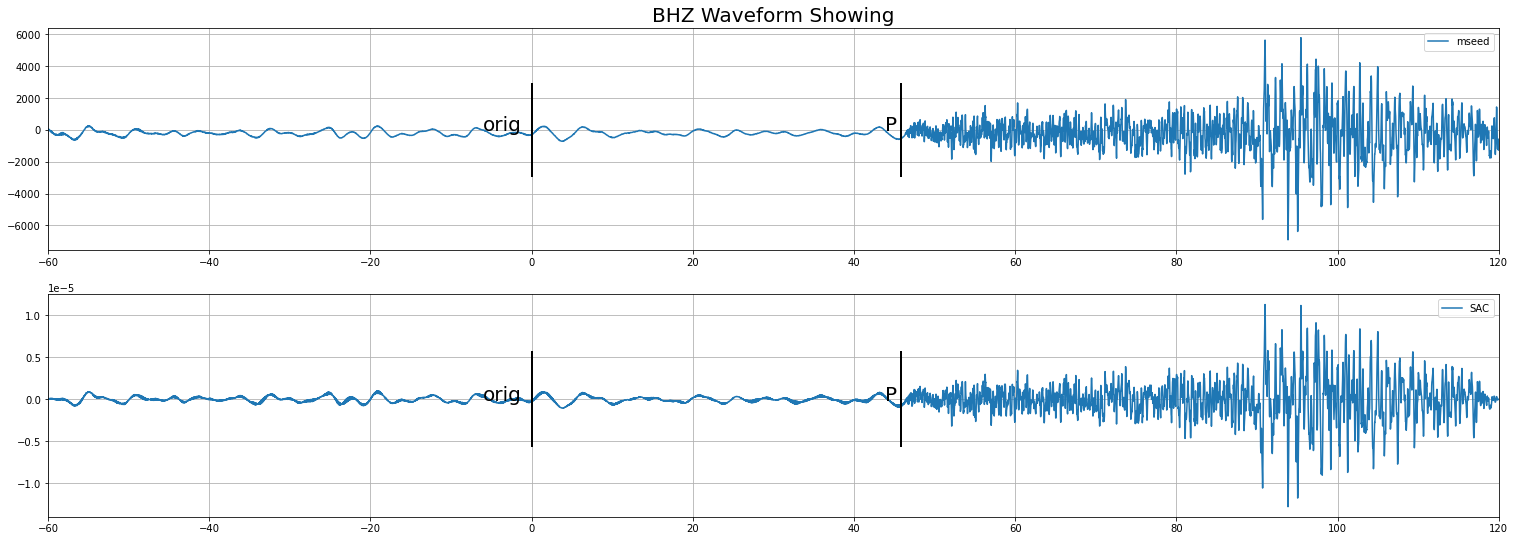

In [13]:
# Quick waveform check
from obspy import read
from obspy.io.sac import SACTrace 
import matplotlib.pyplot as plt
import numpy as np

#wtdir="/home/tianjue/SPMS/NCA/Data/Download"

ch = 'BHZ'

wtdir = "/home/ketan/IndiaConnectNTU/Week5-6/DownloadData/Data/Download3"

evt = "20211019000331986"

#evt = 20211101134345622
stati = 'C1.BO01'

#st = read(f"{wtdir}/miniseed/{evt}/CI.CCC..BHZ.mseed")

st = read(f"{wtdir}/miniseed{ch}/{evt}/{stati}..{ch}.mseed")

#st2 = read(f"{wtdir}/SAC/{evt}/CI.CCC..BHZ.SAC")

st2 = read(f"{wtdir}/SAC_raw/SAC{ch}_raw/{evt}/{stati}..{ch}.SAC")

d1 = st[0].data
d1 -= d1[0]

d2 = st2[0].data
d2 -= d2[0]

#sac = SACTrace.read(f"{wtdir}/SAC/{evt}/CI.CCC..BHZ.SAC")

sac = SACTrace.read(f"{wtdir}/SAC_raw/SAC{ch}_raw/{evt}/{stati}..{ch}.SAC")

t = np.arange(0+sac.b, st[0].stats.npts / st[0].stats.sampling_rate+sac.b, st[0].stats.delta)
t2 = np.arange(0+sac.b, st2[0].stats.npts / st2[0].stats.sampling_rate+sac.b, st2[0].stats.delta)

plt.figure(figsize=(26,9))
plt.subplot(211)
plt.plot(t,d1,label="mseed")
#origin time
plt.plot([sac.o, sac.o], [-1*max(d1)*0.5, max(d1)*0.5], color="black", linewidth=2)
plt.text(sac.o-6, -1*max(d1)*0.01, 'orig', fontsize=20)
#first-P arrival
plt.plot([sac.t1, sac.t1], [-1*max(d1)*0.5, max(d1)*0.5], color="black", linewidth=2)
plt.text(sac.t1-2, -1*max(d1)*0.01, 'P', fontsize=20)
plt.xlim(-60, 120)
plt.legend()
plt.title(ch+' Waveform Showing', fontsize=20)
plt.grid()

plt.subplot(212)
plt.plot(t,d2,label="SAC")
#origin time
plt.plot([sac.o, sac.o], [-1*max(d2)*0.5, max(d2)*0.5], color="black", linewidth=2)
plt.text(sac.o-6, -1*max(d2)*0.01, 'orig', fontsize=20)
#first-P arrival
plt.plot([sac.t1, sac.t1], [-1*max(d2)*0.5, max(d2)*0.5], color="black", linewidth=2)
plt.text(sac.t1-2, -1*max(d2)*0.01, 'P', fontsize=20)
plt.xlim(-60, 120)
plt.legend()
plt.grid()
print(sac.t1)
plt.show()